# **Reconocimiento de partituras musicales**

En este documento se condensa todo el código realizado para el reconocimiento de partituras musicales. De este modo, se pretende que la ejecución y la interpretación de las funciones implementadas sea la más clara y sencilla posible.

Este trabajo ha sido realizado por:

- Carlos Bermejo Soria
- Tadeo Cabrera Gómez
- Jesús Solís Ortega

## **Índice**

1. [Inicialización](#1-inicialización)
2. [Segmentación por Regiones](#2-segmentación-por-regiones)
   1. [Transformación Binaria](#21-transformación-binaria)
   2. [Histograma de Proyección Horizontal](#22-histograma-de-proyección-horizontal)
   3. [Segmentación por Regiones](#23-segmentación-por-regiones)
3. [Preprocesamiento de imágenes](#3-preprocesamiento-de-imágenes)
   1. [Filtrado de líneas del pentagrama](#31-filtrado-de-líneas-del-pentagrama)

### **1. Inicialización**

Antes de comenzar la ejecución de las funciones implementadas en el trabajo, es fundamental suplir las necesidades de las mismas. Parra ello, se ha preparado una celda código que recoge todas las necesidades mínimas del código utilizado. Esta celda es fundamental ejecutarla para el correcto funcionamiento del resto del cuadernillo. Para ejecutarla haga clic en la celda y presione _CONTROL + ENTER_.

In [2]:
%%capture

#Comente la línea "%%capture" si desea ver la consola de instalación
#Creación de un entorno virtual
!pip install virtualenv
!python -m venv venv
!venv\Scripts\activate

#Instalación de los paquetes de "requirements.txt"
!python --version
!python.exe -m pip install --upgrade pip
!pip install -r ../requirements.txt

#Importación de las librerías
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage

#Cambio a la ruta de los archivos de python de nuestro programa
import sys
sys.path.append('../src')

En caso de que exista un error en la instalación, contacte con el equipo de trabajo lo antes posible. Si desea ver una traza del error, puede comentar la línea _"%%capture"_ utilizando la almohadilla (#).

Además, es indispensable cargar la imagen de prueba. Existen diversas fotos en la batería de prueba, si desea cambiar la imagen con la que probar las funciones, **cambie el parámetro n** de la siguiente celda a un valor entre 1 y 10. Cada una de las fotografías se corresponde con una partitura diferente.

In [3]:
n = 3 #Elija un valor entre 1 y 10 para "n"

n = 1 if (n>10 or n<1) else n
image = cv2.imread(r'../images/Test Sheet '+str(n)+'.png')
print("Imagen "+str(n)+" leída correctamente")

Imagen 3 leída correctamente


Si desea recargar los módulos de python, cargue la siguiente celda.

In [42]:
from importlib import reload
import stuff_region_segmentation
import note_recognition
import image_preprocessing
import accidental_and_rest_recognition
reload(stuff_region_segmentation)
reload(note_recognition)
reload(image_preprocessing)
reload(accidental_and_rest_recognition)

print("Módulos recargados")

Módulos recargados


### **2. Segmentación por regiones**

La segmentación por regiones es un proceso que permite al sistema adivinar las posiciones de las líneas del pentagrama. Esto facilita el reconocimiento de notas que se realizará posteriormente.

### 2.1. Transformación binaria

La transformación binaria toma la imagen original de la partitura y convierte sus niveles digitales en valores de 0 o 255 exclusivamente. Para ello, hace uso de la función _threshold_ de OpenCV.

En el ejemplo, la transformación binaria se realiza sobre la imagen y el resultado es mostrado en pantalla. Además, se realiza una imprimición de los niveles digitales de la imagen binaria para comprobar que, efectivamente, funciona.


- Niveles digitales de la imagen original:  {0, 134, 14, 150, 153, 26, 32, 169, 42, 51, 180, 187, 66, 196, 205, 81, 213, 89, 222, 101, 231, 240, 118, 249, 255} 

- Niveles digitales de la imagen binaria:  {0, 255} 



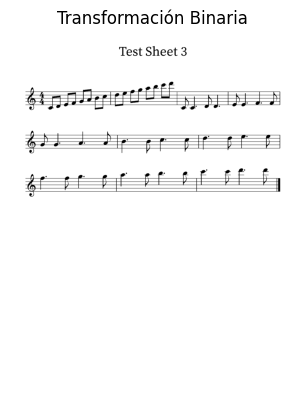

In [43]:
import stuff_region_segmentation

binary_image = stuff_region_segmentation.binary_transform(image)
digital_levels_image = set(image.flatten())
digital_levels_binary = set(binary_image.flatten())

print("- Niveles digitales de la imagen original: ",digital_levels_image,"\n")
print("- Niveles digitales de la imagen binaria: ",digital_levels_binary, "\n")

plt.imshow(binary_image, cmap='gray')
plt.axis('off') 
plt.title('Transformación Binaria')
plt.show()



### 2.2. Proyección horizontal

La proyección horizontal es un método que permite obtener un histograma de proyección horizontal de cada una de las líneas horizontales que componen la imagen. La entrada de la función es una imagen binaria y el resultado de la misma es una imagen que representa visualmente el histograma de proyección horizontal.

Podemos ver que cada uno de los picos obvios del histograma, se corresponde con cada una de las líneas del pentagrama.

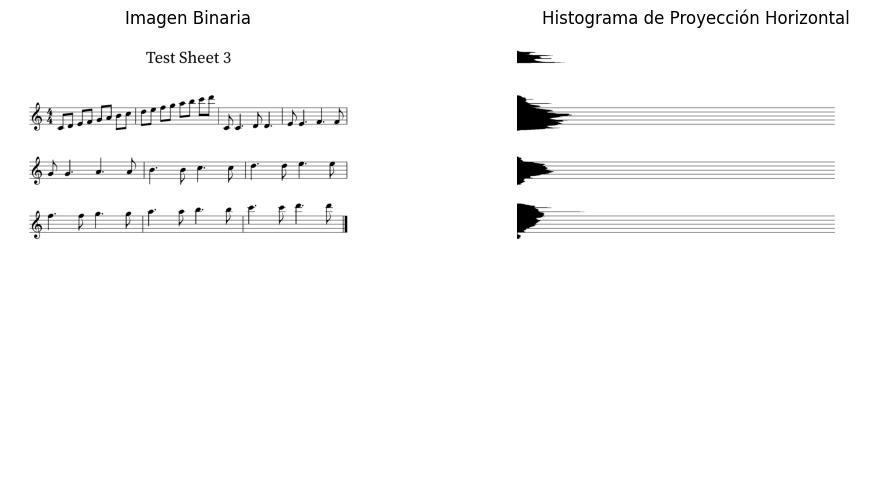

In [44]:
import stuff_region_segmentation

horizontal_proyecyion_histogram = stuff_region_segmentation.horizontal_projection(binary_image)
histogram_image = stuff_region_segmentation.get_histogram_image(binary_image, horizontal_proyecyion_histogram)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(binary_image, cmap='gray');axes[0].set_title('Imagen Binaria');axes[0].axis('off')
axes[1].imshow(histogram_image, cmap='gray');axes[1].set_title('Histograma de Proyección Horizontal');axes[1].axis('off')
plt.show()

### 2.3. Segmentación por regiones

El objetivo de la segmentación por regiones es segmentar partes del pentagrama para trabajar en ellas independientemente a posteriori. Nuestra función recibe como parámetro una imagen que represente el histograma de proyección horizontal y genera una imagen que delimita las líneas del pentagrama.

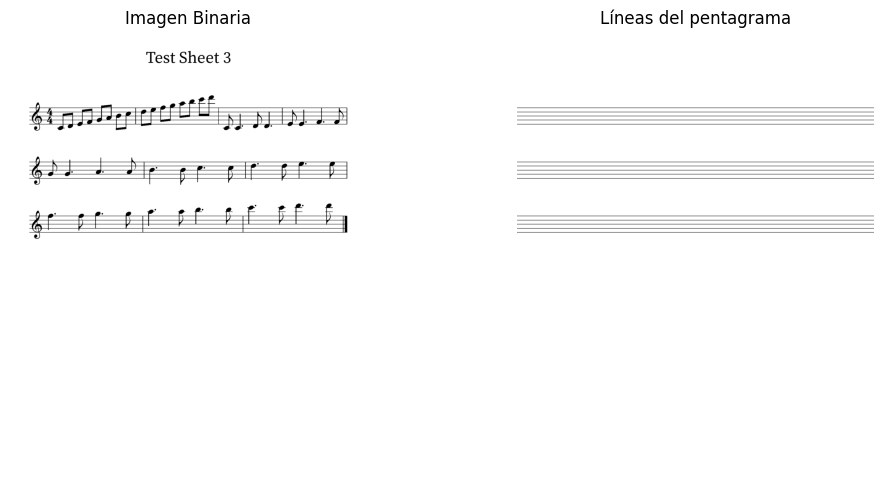

In [45]:
import stuff_region_segmentation

staff_lines = stuff_region_segmentation.region_segmentation(binary_image, horizontal_proyecyion_histogram)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(binary_image, cmap='gray');axes[0].set_title('Imagen Binaria');axes[0].axis('off')
axes[1].imshow(staff_lines, cmap='gray');axes[1].set_title('Líneas del pentagrama');axes[1].axis('off')
plt.show()

Una vez hemos obtenido las líneas del pentagrama en una imagen, podemos obtener las columnas que tienen líneas de pentagrama y las posiciones de cada una de estas líneas dentro de la imagen, separadas por las distintas filas de la partitura.

In [46]:
import stuff_region_segmentation

columns_with_lines = stuff_region_segmentation.get_black_column_positions(staff_lines)
print('\n- Columnas con líneas de pentagrama:', columns_with_lines,'\n')

staff_lines_positions = stuff_region_segmentation.get_staff_lines_positions(columns_with_lines)
print('- Posiciones de las líneas del pentagrama:', staff_lines_positions,'\n')


- Columnas con líneas de pentagrama: [360, 361, 380, 381, 399, 400, 418, 419, 438, 439, 618, 619, 637, 638, 657, 658, 676, 677, 696, 697, 875, 876, 895, 896, 914, 915, 934, 935, 953, 954] 

- Posiciones de las líneas del pentagrama: [[360, 380, 400, 418, 438], [618, 638, 658, 676, 696], [876, 896, 914, 934, 953]] 



### **3. Preprocesamiento de imágenes**

Durante el preprocesamiento de imágenes, se prepara la imagen eliminando las líneas del pentagrama y recuperando los posibles daños causados a las notas y símbolos que aparecen a lo largo de la partitura.

### 3.1. Filtrado de líneas del pentagrama

Para el filtrado de las líneas se utilizan tanto la imagen binaria como la imagen con las líneas del pentagrama. Se utilizan las funciones _bitwise_not_, _bitwise_and_ y _bitwise_or_ para combinar las imágenes de modo que finalmente se obtenga una nueva imagen que solo contiene los símbolos musicales.

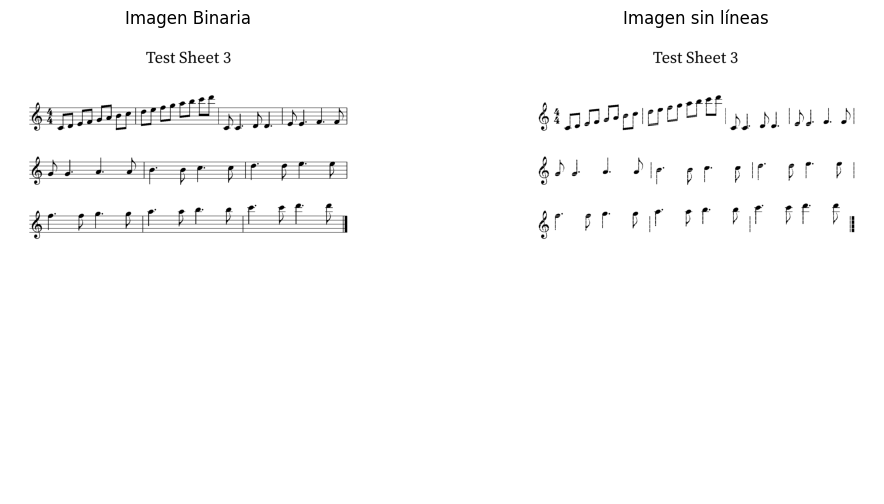

In [47]:
import image_preprocessing

image_without_lines = image_preprocessing.staff_line_filtering(binary_image, staff_lines)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(binary_image, cmap='gray');axes[0].set_title('Imagen Binaria');axes[0].axis('off')
axes[1].imshow(image_without_lines, cmap='gray');axes[1].set_title('Imagen sin líneas');axes[1].axis('off')
plt.show()